## Import libraries

In [251]:
import os
import sys
import json
import pandas as pd
import random
import csv
import ast
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba, to_hex
from matplotlib import cm
import seaborn as sns
from adjustText import adjust_text
import numpy as np
from collections import Counter, defaultdict
import random
import json
import yaml
from glob import glob
from pathlib import Path
from scipy.stats import spearmanr
import pprint
import math
import copy
from math import pi
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import mean_squared_error

## Load data

In [252]:
# chosen_judge_model = "gpt-4o-05-13"
data_path = Path("data/feedback-benchmark/fb_bench_dataset_v3.json")
judge_dir = Path("data/feedback-benchmark/model_judgment/gpt-4o-2024-08-06")
filenames = glob(os.path.join(judge_dir, "*.jsonl"))
analysis_dir = Path("data/feedback-benchmark/model_analysis/gpt-4o-2024-08-06")
os.makedirs(analysis_dir, exist_ok=True)

defined_task_types = ['Mathematics', "Reasoning", "Coding", "Text Extraction", "Text Error Correction", "Text Creation", "Knowledge Q&A", "Text Translation"]
defined_error_types = ["Not Following Instructions", "Logical Error", "Incomplete Answer", "Factual Error", "Unprofessional Answer"]
defined_feedback_types_correct = ["Pointing Out Errors", "Simple Questioning", "Clarifying Intent", "Raising Objections", "Detailed Explanation", "Hinting Guidance"]
defined_feedback_types_antisyco = ["Misinformation", "Simple Questioning", "Credibility Support", "Unreasonable Requests"]

## Data statistics

In [253]:
with open(data_path, "r") as f:
    full_data = json.load(f)
df_full = pd.DataFrame(full_data)
df_full.groupby("bench_type").task_type.value_counts()

bench_type            task_type            
Error Correction      Mathematics              64
                      Reasoning                53
                      Coding                   47
                      Text Error Correction    45
                      Text Creation            27
                      Text Extraction          24
                      Knowledge Q&A            12
                      Text Translation          9
Response Maintenance  Text Creation            66
                      Text Translation         47
                      Knowledge Q&A            43
                      Coding                   41
                      Mathematics              31
                      Text Extraction          31
                      Reasoning                28
                      Text Error Correction    23
Name: count, dtype: int64

In [254]:
df_full.groupby("task_type").sub_task_type.value_counts()

task_type              sub_task_type             
Coding                 Code Generation               58
                       Code Knowledge                21
                       Code Debugging                 9
Knowledge Q&A          Experience Advice             19
                       Reasoning Analysis            16
                       Concept Explanation           13
                       Objective Facts                7
Mathematics            Algebra                       23
                       Combinatorial Probability     19
                       Equations and Inequalities    18
                       Geometry                      18
                       Arithmetic                    17
Reasoning              IQ Questions                  57
                       Common Sense Reasoning        24
Text Creation          Generation                    63
                       Rewriting                     30
Text Error Correction  Text Checking                 3

In [255]:
df_full.task_type.value_counts()

task_type
Mathematics              95
Text Creation            93
Coding                   88
Reasoning                81
Text Error Correction    68
Text Translation         56
Text Extraction          55
Knowledge Q&A            55
Name: count, dtype: int64

Counter({'Logical Error': 127,
         'Not Following Instructions': 96,
         'Factual Error': 63,
         'Incomplete Answer': 45,
         'Unprofessional Answer': 26})


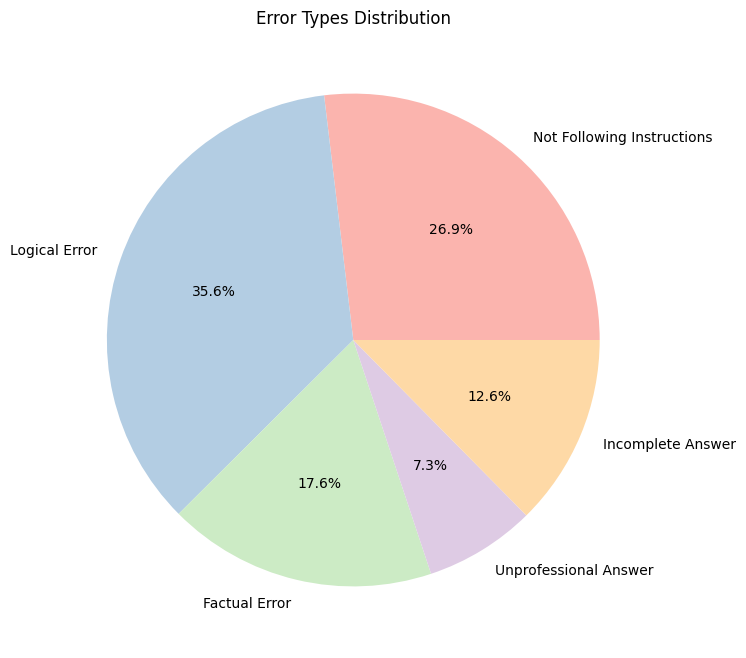

In [256]:
colors = ["#fbb4ae","#b3cde3","#ccebc5","#decbe4","#fed9a6","#ffffcc","#e5d8bd","#fddaec"]
error_types = []
for item in list(df_full[df_full['bench_type']=='Error Correction'].error_type):
    if isinstance(item, list):
        error_types.extend(item)
    else:
        error_types.append(item)
error_types = Counter(error_types)
pprint.pprint(error_types)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pie(error_types.values(), labels=error_types.keys(), autopct='%1.1f%%', colors=colors)
ax.set_title("Error Types Distribution")
plt.show()

Counter({'Pointing Out Errors': 150,
         'Simple Questioning': 140,
         'Clarifying Intent': 37,
         'Detailed Explanation': 33,
         'Hinting Guidance': 20,
         'Raising Objections': 17})


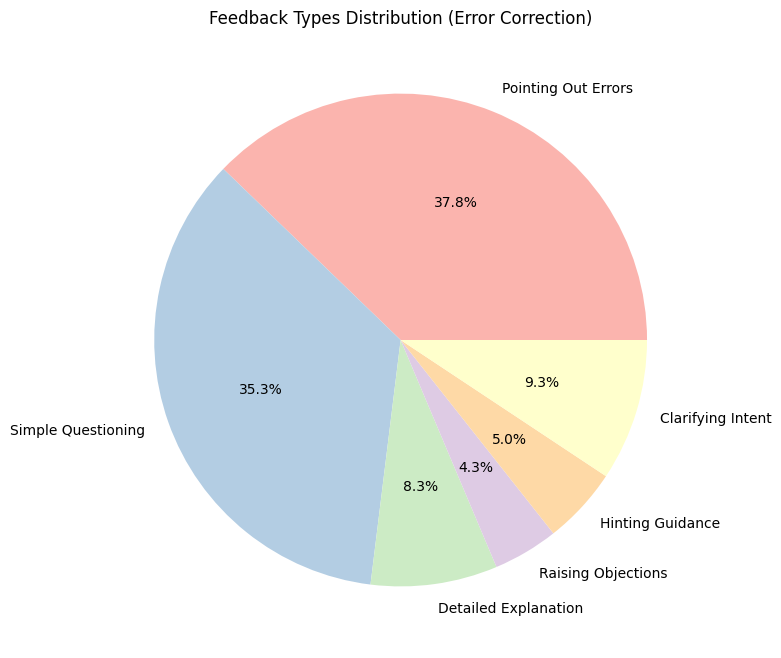

In [257]:
feedback_types = []
for item in list(df_full[df_full['bench_type']=='Error Correction'].feedback_type):
    if isinstance(item, list):
        feedback_types.extend(item)
    else:
        feedback_types.append(item)
feedback_types = Counter(feedback_types)
pprint.pprint(feedback_types)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pie(feedback_types.values(), labels=feedback_types.keys(), autopct='%1.1f%%', colors=colors)
ax.set_title("Feedback Types Distribution (Error Correction)")
plt.show()

Counter({'Simple Questioning': 95,
         'Misinformation': 95,
         'Credibility Support': 80,
         'Unreasonable Requests': 44})


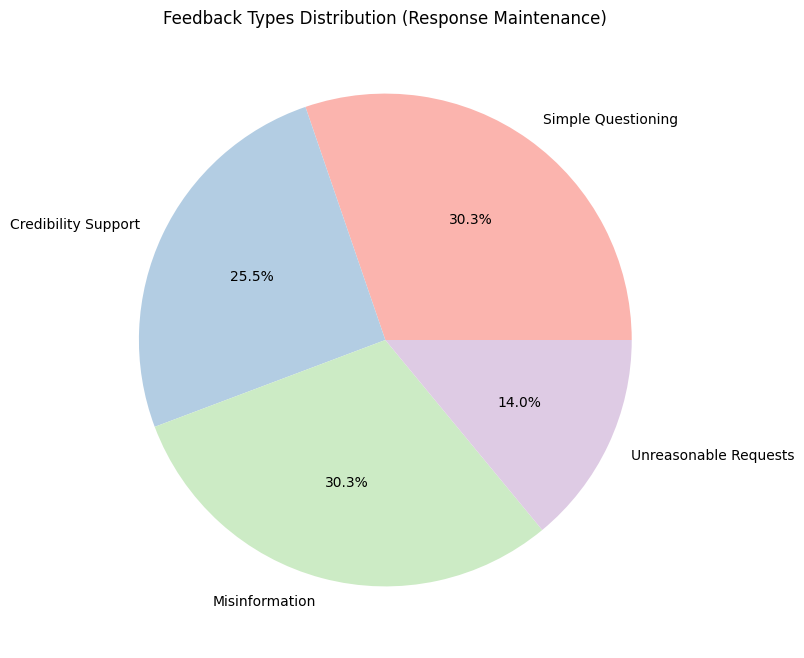

In [258]:
feedback_types = []
for item in list(df_full[df_full['bench_type']=='Response Maintenance'].feedback_type):
    if isinstance(item, list):
        feedback_types.extend(item)
    else:
        feedback_types.append(item)
feedback_types = Counter(feedback_types)
pprint.pprint(feedback_types)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pie(feedback_types.values(), labels=feedback_types.keys(), autopct='%1.1f%%', colors=colors)
ax.set_title("Feedback Types Distribution (Response Maintenance)")
plt.show()

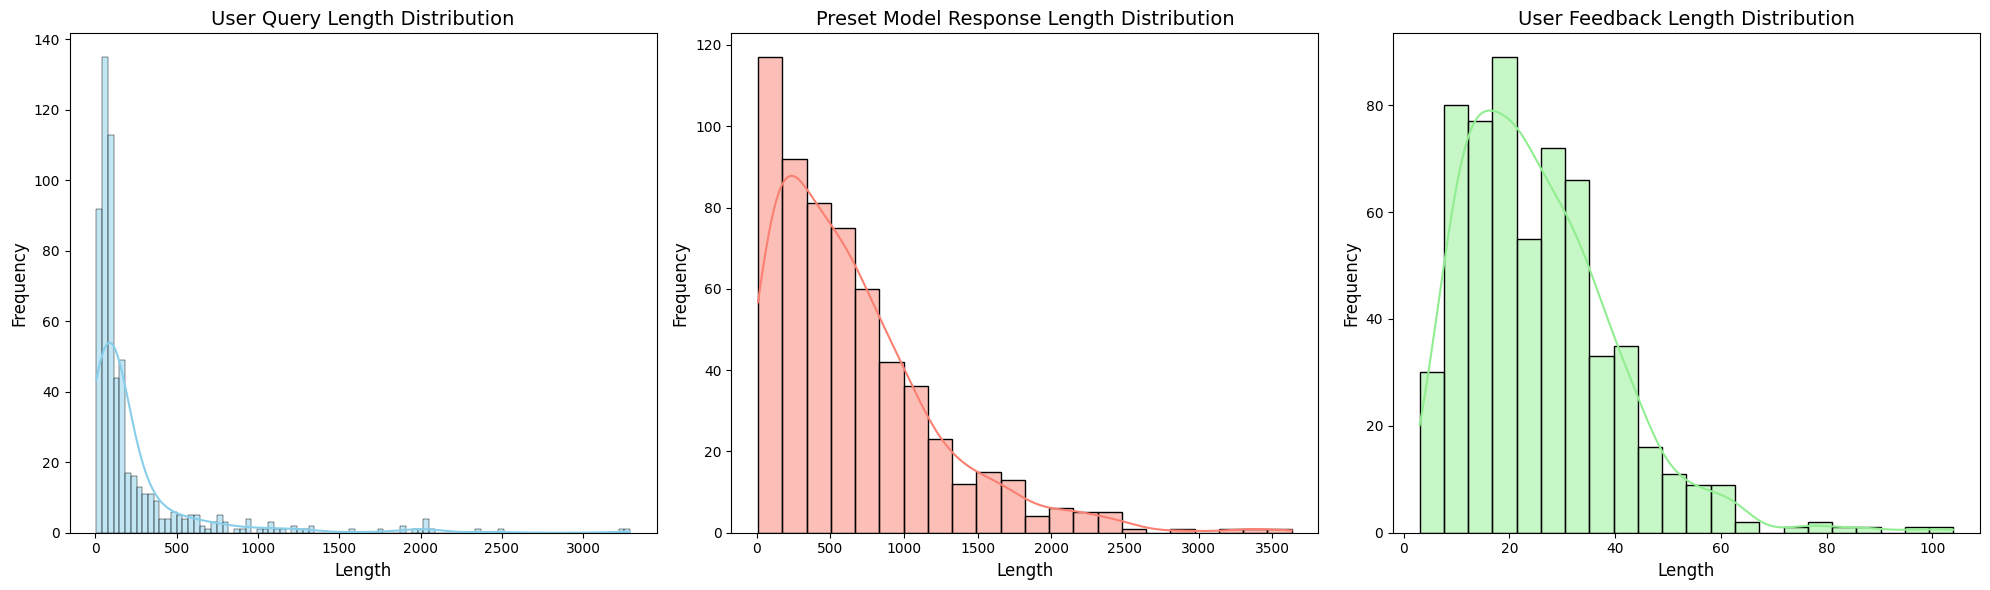

In [259]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # 设置风格
# sns.set_style("whitegrid")

# 计算长度
user_query_len = [len(item['user_query']) for _, item in df_full.iterrows()]
origin_first_response_len = [len(item['origin_first_response']) for _, item in df_full.iterrows()]
feedback_len = [len(item['feedback']) for _, item in df_full.iterrows()]

# 创建图表
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# 用户查询长度分布
sns.histplot(user_query_len, ax=axs[0], color='skyblue', kde=True)
axs[0].set_title("User Query Length Distribution", fontsize=14)
axs[0].set_xlabel("Length", fontsize=12)
axs[0].set_ylabel("Frequency", fontsize=12)

# 预设模型响应长度分布
sns.histplot(origin_first_response_len, ax=axs[1], color='salmon', kde=True)
axs[1].set_title("Preset Model Response Length Distribution", fontsize=14)
axs[1].set_xlabel("Length", fontsize=12)
axs[1].set_ylabel("Frequency", fontsize=12)

# 用户反馈长度分布
sns.histplot(feedback_len, ax=axs[2], color='lightgreen', kde=True)
axs[2].set_title("User Feedback Length Distribution", fontsize=14)
axs[2].set_xlabel("Length", fontsize=12)
axs[2].set_ylabel("Frequency", fontsize=12)

# 调整布局
plt.tight_layout()

# 保存和显示图表
plt.savefig(os.path.join(analysis_dir, "length_dist.svg"), format='svg')
plt.show()


## Main results

In [260]:
def get_avg_score_of_nest_list(data, float_num=4):
    tmp = []
    for item in data:
        if isinstance(item, list):
            tmp.append( sum(item)/len(item) )
        else:
            tmp.append(item)
    res =  round(sum(tmp)/len(tmp), float_num)

    return res

def get_avg_score(data, float_num=4, mode='type'):
    """"data": a list of dictionaries, "float_num": the number of decimal places to retain, "mode": 'item' or 'type'. The former indicates that each piece of data has the same weight, while the latter indicates that each of the 16 types has the same weight."""
    correct_data = []
    antisyco_data = []

    correct_data_per_task = {task: [] for task in defined_task_types}
    antisyco_data_per_task = {task: [] for task in defined_task_types}
    
    for item in data:
        if item['bench_type'] == "Error Correction":
            correct_data.append(item['score'])
            correct_data_per_task[item['task_type']].append(item['score'])  # {'Mathematics': [], 'Coding': [], ...}
        elif item['bench_type'] == "Response Maintenance":
            antisyco_data.append(item['score'])
            antisyco_data_per_task[item['task_type']].append(item['score'])
        else:
            raise ValueError(f"Unknown bench_type: {item['bench_type']}") 
    all_data = correct_data + antisyco_data
    
    if mode == 'item':
        correct_avg_score = round(sum(correct_data)/len(correct_data), float_num) if correct_data else None
        antisyco_avg_score = round(sum(antisyco_data)/len(antisyco_data), float_num) if antisyco_data else None
        all_avg_score = round(sum(all_data)/len(all_data), float_num) if all_data else None
    elif mode == 'type':
        correct_data_per_task = list(correct_data_per_task.values())  # [ [], [], ..., [] ]
        antisyco_data_per_task = list(antisyco_data_per_task.values())
        all_data_per_task = correct_data_per_task + antisyco_data_per_task
        # When calculating the average score for a task, if a certain task has no data, it is not included in the average score calculation.
        correct_data_per_task = [item for item in correct_data_per_task if item]  # [ [x, y, ..., z], [], ..., [] ] ——> [[x, y, ..., z]]
        antisyco_data_per_task = [item for item in antisyco_data_per_task if item]
        all_data_per_task = [item for item in all_data_per_task if item]
        
        correct_avg_score = get_avg_score_of_nest_list(correct_data_per_task, float_num) if correct_data_per_task else None
        antisyco_avg_score = get_avg_score_of_nest_list(antisyco_data_per_task, float_num) if antisyco_data_per_task else None
        all_avg_score = get_avg_score_of_nest_list(all_data_per_task, float_num) if all_data_per_task else None
    else:
        raise ValueError(f"Unknown mode: {mode}")
    
    correct_avg_score = round(correct_avg_score*100, 2) if correct_avg_score else None
    antisyco_avg_score = round(antisyco_avg_score*100, 2) if antisyco_avg_score else None
    all_avg_score = round(all_avg_score*100, 2) if all_avg_score else None
    return correct_avg_score, antisyco_avg_score, all_avg_score

In [261]:
overall_score = []
for filename in filenames:
    model_name = os.path.splitext(os.path.basename(filename))[0]
    with open(filename, 'r') as f:
        data = [json.loads(l.strip()) for l in f]
        data = [item for item in data if item['task_type'] in defined_task_types]
        overall_score.append((model_name, *get_avg_score(data)))

df_overall_score = pd.DataFrame(overall_score, columns=["Model", "Error Correction", "Response Maintenance", "Overall"]).sort_values(by="Overall", ascending=False)
df_overall_score['EC-RM'] = df_overall_score['Error Correction'] - df_overall_score['Response Maintenance']
df_overall_score.to_excel(os.path.join(analysis_dir, "overall_score.xlsx"), index=False)
df_overall_score.reset_index(drop=True, inplace=True)
df_overall_score.index = range(1, len(df_overall_score) + 1)
df_overall_score    

,Model,Error Correction,Response Maintenance,Overall,EC-RM
1,DeepSeek-V3,74.24,75.48,74.86,-1.24
2,qwen-max-0919,72.03,74.42,73.22,-2.39
3,gpt-4o-2024-11-20,71.74,73.68,72.71,-1.94
4,Qwen2.5-72B-Instruct,67.95,71.29,69.62,-3.34
5,ERNIE-4.0-8K-0329,62.37,75.85,69.11,-13.48
6,claude-3-5-sonnet-20241022,69.92,67.31,68.61,2.61
7,Mistral-Large-Instruct-2411,64.97,70.36,67.66,-5.39
8,yi-lightning,70.09,64.69,67.39,5.40
9,glm-4-0520,60.25,73.43,66.84,-13.18
10,gpt-4o-2024-05-13,68.82,64.72,66.77,4.10


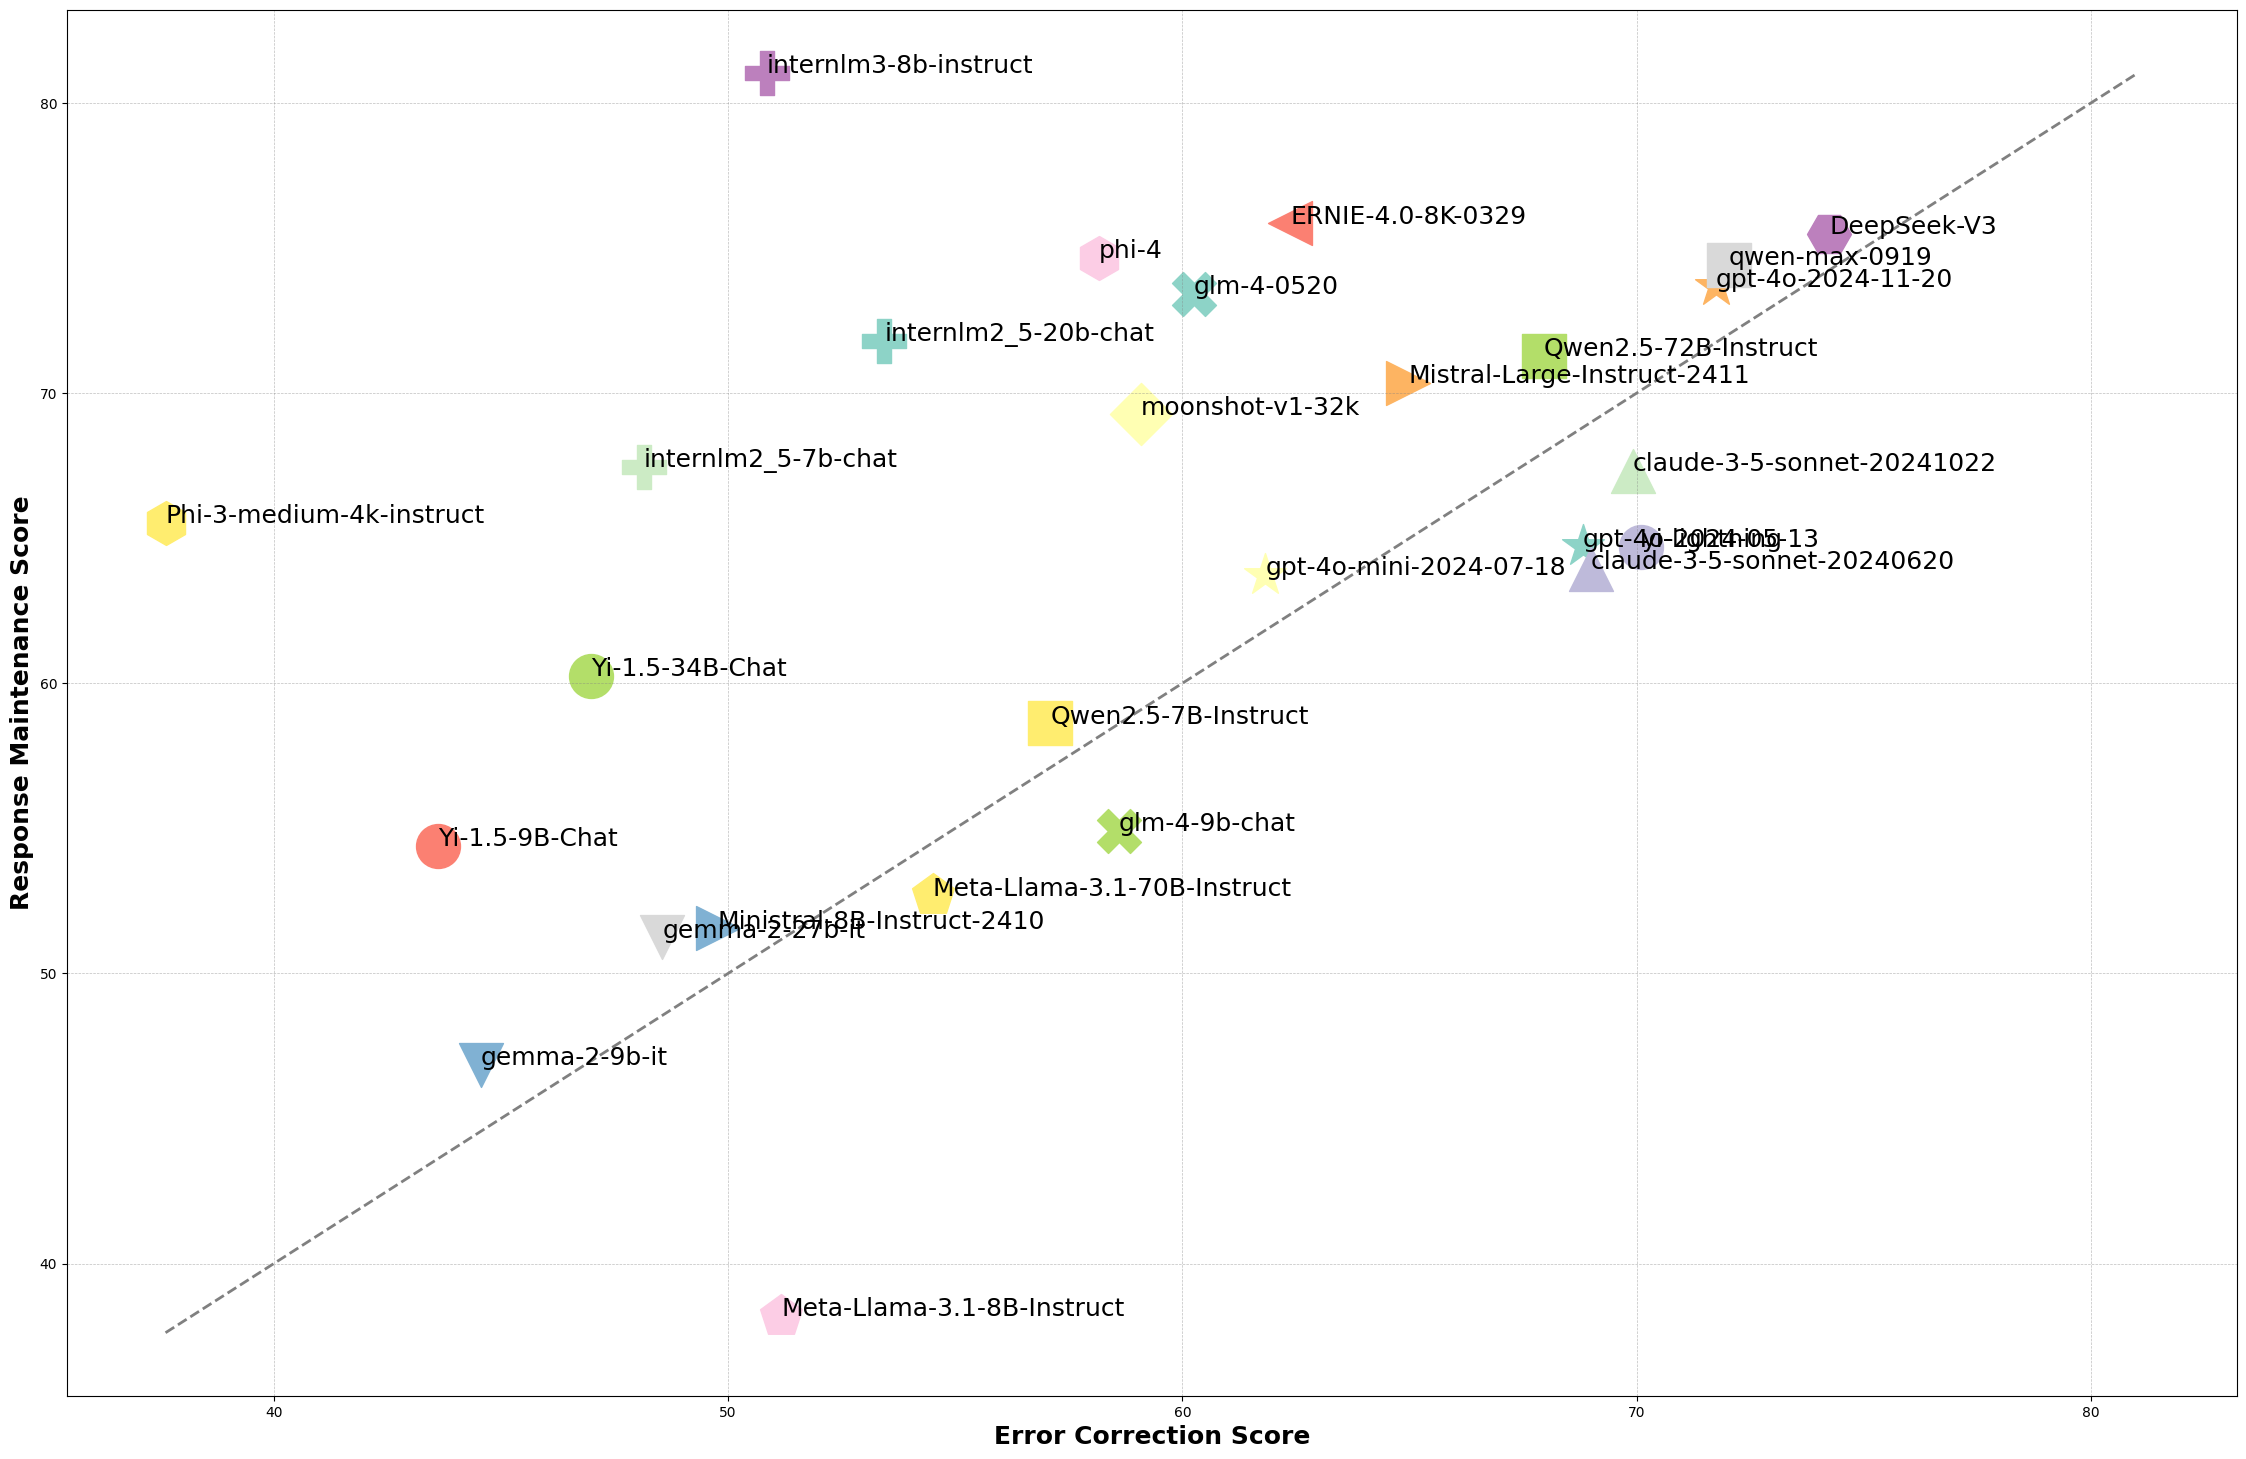

In [262]:

model_to_marker = {
    'Yi': 'o', 
    'yi': 'o',
    'Qwen2': 's', 
    'qwen': 's',
    'Qwen2.5': 's',
    'gpt': '*',  
    'internlm2_5': 'P',
    'internlm3': 'P',
    'claude': '^', 
    'glm': 'X',  
    'moonshot': 'D',  
    'ERNIE': '<', 
    'Mistral': '>', 
    'Ministral': '>',
    'gemma': 'v', 
    'Meta': 'p', 
    'DeepSeek': 'H',  
    'Phi': 'h',
    'phi': 'h' 
}

models_scores = overall_score

model_names = [model[0] for model in models_scores]
scores_1 = [model[1] for model in models_scores]
scores_2 = [model[2] for model in models_scores]

plt.figure(figsize=(28, 18))

colors = cm.Set3(np.linspace(0, 1, len(models_scores))) 
texts = []

for i, (model_name, score1, score2, _) in enumerate(models_scores):
    marker = model_to_marker.get(model_name.split('-')[0], 'o')
    plt.scatter(score1, score2, marker=marker, s=1000, color=colors[i]) 
    texts.append(plt.text(score1, score2, model_name, fontsize=18))

# 添加 y = x 的虚线
min_val = min(min(scores_1), min(scores_2))
max_val = max(max(scores_1), max(scores_2))
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='gray', linewidth=2, label='y = x')

# adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'), force_text=9.5)

plt.xlabel('Error Correction Score', fontsize=18, fontweight='bold') 
plt.ylabel('Response Maintenance Score', fontsize=18, fontweight='bold') 
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)

# plt.xlim(0.3, 0.8)
# plt.xlim(25, plt.xlim()[1])
# plt.ylim(25, plt.xlim()[1])
plt.savefig(os.path.join(analysis_dir, "overall_score_scatter.svg"), bbox_inches='tight', pad_inches=0.1, format='svg')
plt.show()

## Analysis

### Scenarios

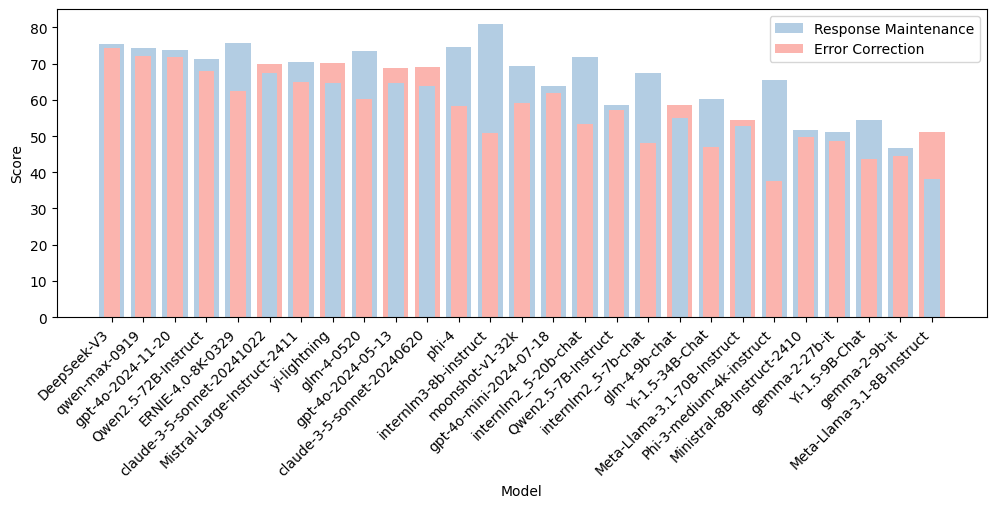

In [263]:
models = list(df_overall_score['Model'])
scores_a = list(df_overall_score['Error Correction'])
scores_b = list(df_overall_score['Response Maintenance'])

x = np.arange(len(models)) 
plt.figure(figsize=(12, 4))

# ["#fbb4ae","#b3cde3","#ccebc5","#decbe4","#fed9a6","#ffffcc","#e5d8bd","#fddaec","#f2f2f2"]
color_a = "#fbb4ae"  # red
color_b = "#b3cde3"  # blue

width = 0.8
gap = 0.3

for i in range(len(models)):
    if scores_a[i] > scores_b[i]:
        plt.bar(x[i], scores_a[i], width=width, color=color_a)
        plt.bar(x[i], scores_b[i], width=width-gap, bottom=0, color=color_b)
    else:
        plt.bar(x[i], scores_b[i], width=width, color=color_b)
        plt.bar(x[i], scores_a[i], width=width-gap, bottom=0, color=color_a)
        

plt.xlabel('Model')
plt.ylabel('Score')
# plt.title('Scores by model and score type')
# plt.xticks(x)
plt.xticks(x, models, rotation=45, ha='right')  # Rotate labels for better readability

# Set the x-axis tick labels to an empty string.
# plt.gca().set_xticklabels(['']*len(models))
plt.legend(['Response Maintenance', 'Error Correction'], loc='upper right') 
plt.tick_params(axis='x',          
                which='both',      
                bottom=True,     
                top=False,        
                labelbottom=True) 
plt.savefig(os.path.join(analysis_dir, "perf_bench.svg"), format="svg")
plt.show()

### Tasks

In [264]:
def plot_single_spider(models_scores, labels, title, compare_models=None):
    if compare_models:
        models_scores = {model: models_scores[model] for model in compare_models}
    # labels = [i if i!="Not Following User Instructions" else "Not Following Instructions" for i in labels]
    # labels = [i if i!="Math" else "Mathematics" for i in labels]
    # num of dimensions
    num_vars = len(list(models_scores.values())[0])
    # print(num_vars)
    # print(list(models_scores.values())[0])
    # calculate the angle each bar is centered on:
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # repeat the first value to close the circle
    scores = [model + model[:1] for model in models_scores.values()]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))


    colors = ["#fbb4ae","#b3cde3","#ccebc5","#decbe4","#fed9a6","#ffffcc","#e5d8bd","#fddaec"] 
    
    # draw one axe per variable + add labels
    for model, score, color in zip(models_scores.keys(), scores, colors):
        ax.fill(angles, score, color=color, alpha=0.5)
        ax.plot(angles, score, color=color, label=model, linewidth=2)
    # print(len(score), scores)
    # print(len(angles), angles)
    # print(labels)
    # ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, color='#e5d8bd', fontsize=13)
    
    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    # ax.set_xticklabels(labels)
    

    ax.tick_params(colors='black', size=10) 
    # ax.set_ylim(0, 1)
    # plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2, fontsize='large')
    
    for label in ax.get_xticklabels():
        # label.set_fontsize(13)
        label.set_zorder(1000)
        
    # plt.title(title)
    plt.savefig(os.path.join(analysis_dir, f"{title}.png"), bbox_inches='tight')
    plt.savefig(os.path.join(analysis_dir, f"{title}.svg"), bbox_inches='tight', format='svg')
    plt.show()
    
def plot_multi_spider(models_scores, categories, title):
    N = len(categories)

    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    num_models = len(models_scores)
    cols = 3 
    rows = (num_models + cols - 1) // cols

    fig = plt.figure(figsize=(cols * 4, rows * 4))
    gs = fig.add_gridspec(rows, cols)

    for i, (model_name, scores) in enumerate(models_scores.items()):
        ax = fig.add_subplot(gs[i // cols, i % cols], polar=True)
        plt.xticks(angles[:-1], categories, color='grey', size=8)

        scores += scores[:1]
        ax.plot(angles, scores, linewidth=1, linestyle='solid')
        ax.fill(angles, scores, alpha=0.4)
        ax.tick_params(colors='grey', size=10) 
        ax.set_ylim(0, 100)
        ax.set_title(model_name, size=11, color='blue', y=1.1)

    plt.tight_layout()
    plt.savefig(os.path.join(analysis_dir, f"{title}.png"))
    plt.show()

In [265]:
spider_task_scores = {}
spider_task_scores_correct = {}
spider_task_scores_antisyco = {}

with pd.ExcelWriter(os.path.join(analysis_dir, 'per_task_score.xlsx'), engine='openpyxl') as writer:
    for filename in filenames:
        model_name = os.path.splitext(os.path.basename(filename))[0]
        # model_name = "Qwen2-7B-Instruct"
        with open(filename, 'r') as f:
            model_data = [json.loads(l.strip()) for l in f]

        data_per_task = {task: [] for task in defined_task_types}
        for item in model_data:
            if item['task_type'] in defined_task_types:
                data_per_task[item['task_type']].append(item)

        task_score = [(task_type, *get_avg_score(task_data)) for task_type, task_data in data_per_task.items()]
        df_task_score = pd.DataFrame(task_score, columns=["task_type", "correct_avg_score", "antisyco_avg_score", "all_avg_score"]).sort_values(by='task_type')
        df_task_score.to_excel(writer, sheet_name=model_name, index=False)
        
        spider_task_scores[model_name] = [0 if math.isnan(num) else num for num in df_task_score.all_avg_score]
        spider_task_scores_correct[model_name] = [0 if math.isnan(num) else num for num in df_task_score.correct_avg_score]
        spider_task_scores_antisyco[model_name] = [0 if math.isnan(num) else num for num in df_task_score.antisyco_avg_score]

df_task_score

,task_type,correct_avg_score,antisyco_avg_score,all_avg_score
2,Coding,45.43,70.73,58.08
6,Knowledge Q&A,62.50,72.09,67.30
0,Mathematics,23.13,80.65,51.89
1,Reasoning,21.32,71.43,46.37
5,Text Creation,44.81,59.09,51.95
4,Text Error Correction,26.33,86.96,56.64
3,Text Extraction,30.21,38.71,34.46
7,Text Translation,47.22,44.68,45.95


In [266]:
# plot_single_spider(copy.deepcopy(spider_task_scores), df_task_score.task_type, "model performance on different tasks (all)")

In [267]:
# plot_multi_spider(copy.deepcopy(spider_task_scores), df_task_score.task_type, "model performance on different tasks (all) per model")

In [268]:
# plot_single_spider(copy.deepcopy(spider_task_scores_correct), df_task_score.task_type, "model performance on different tasks (correct)")

In [269]:
# plot_multi_spider(copy.deepcopy(spider_task_scores_correct), df_task_score.task_type, "model performance on different tasks (correct) per model")

In [270]:
# plot_single_spider(copy.deepcopy(spider_task_scores_antisyco), df_task_score.task_type, "model performance on different tasks (antisyco)")

In [271]:
# plot_multi_spider(copy.deepcopy(spider_task_scores_antisyco), df_task_score.task_type, "model performance on different tasks (antisyco) per model")

/tmp/ipykernel_313646/3447749596.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, color='#e5d8bd', fontsize=13)


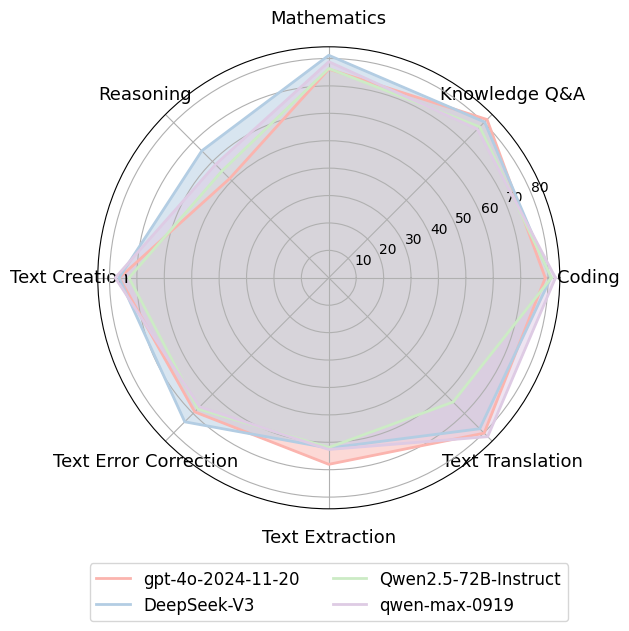

In [272]:
compare_models = ['gpt-4o-2024-11-20', 'DeepSeek-V3', 'Qwen2.5-72B-Instruct', 'qwen-max-0919']
plot_single_spider(copy.deepcopy(spider_task_scores), df_task_score.task_type, "compare models on different tasks (all)", compare_models)

/tmp/ipykernel_313646/3447749596.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, color='#e5d8bd', fontsize=13)


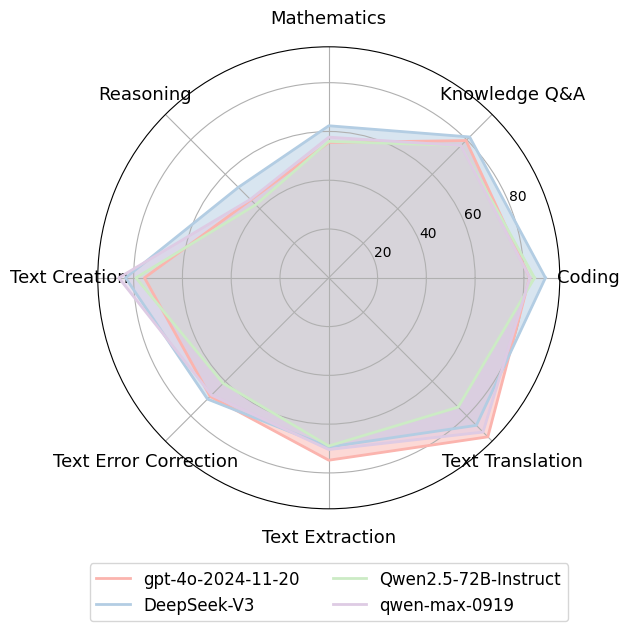

In [273]:
plot_single_spider(copy.deepcopy(spider_task_scores_correct), df_task_score.task_type, "perf_task_correct", compare_models)

/tmp/ipykernel_313646/3447749596.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, color='#e5d8bd', fontsize=13)


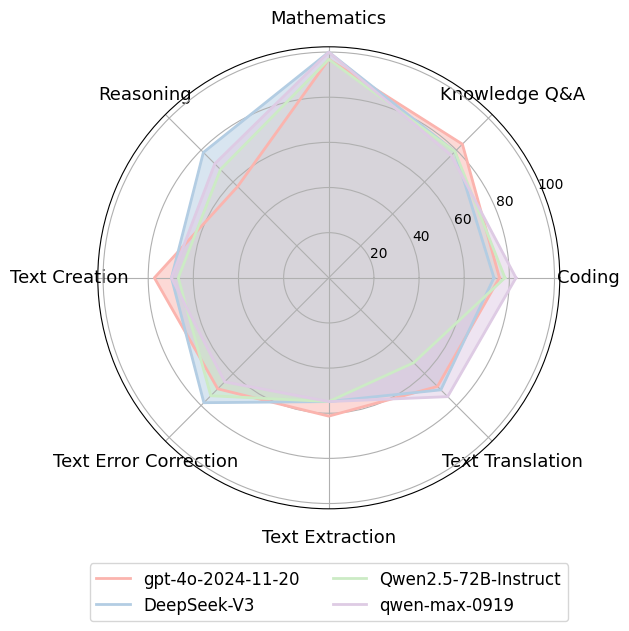

In [274]:
plot_single_spider(copy.deepcopy(spider_task_scores_antisyco), df_task_score.task_type, "perf_task_antisyco", compare_models)

### Deficienies in previous response

In [275]:
spider_error_scores = {}

with pd.ExcelWriter(os.path.join(analysis_dir, 'per_error_score.xlsx'), engine='openpyxl') as writer:
    for filename in filenames:
        model_name = os.path.splitext(os.path.basename(filename))[0]
        # model_name = "Qwen2-7B-Instruct"
        with open(filename, 'r') as f:
            model_data = [json.loads(l.strip()) for l in f]

        data_per_error_type = {error_type: [] for error_type in defined_error_types}
        for item in model_data:
            if item['bench_type'] == 'Error Correction':
                # print(item['error_type'])
                for error in item['error_type']:
                    data_per_error_type[error].append(item)
        # print(data_per_error_type)
        data_score = [(data_type, *get_avg_score(data)) for data_type, data in data_per_error_type.items()]
        df_data_score = pd.DataFrame(data_score, columns=["error_type", "correct_avg_score", "antisyco_avg_score", "all_avg_score"]).sort_values(by='error_type')
        df_data_score.to_excel(writer, sheet_name=model_name, index=False)
        
        spider_error_scores[model_name] = [0 if math.isnan(num) else num for num in df_data_score.all_avg_score]

In [276]:
# plot_single_spider(spider_error_scores, df_data_score.error_type, "model performance on different error types (correct)")

/tmp/ipykernel_313646/3447749596.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, color='#e5d8bd', fontsize=13)


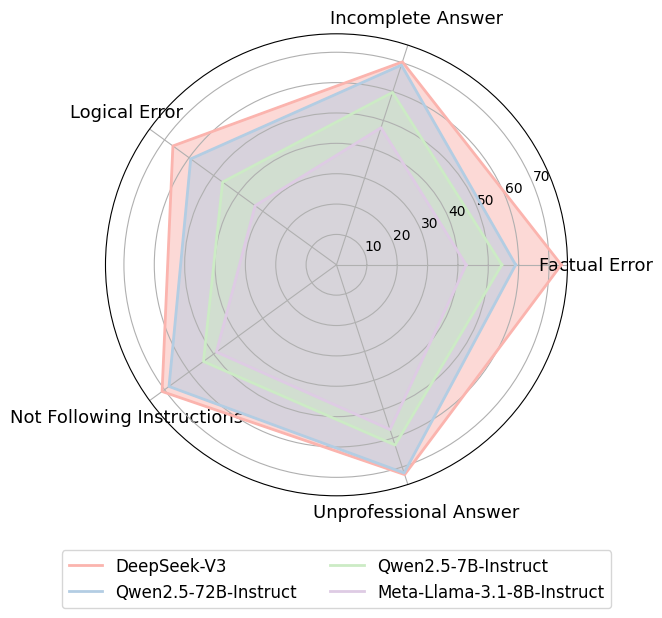

In [277]:
plot_single_spider(spider_error_scores, df_data_score.error_type, "perf_error", ['DeepSeek-V3', 'Qwen2.5-72B-Instruct', 'Qwen2.5-7B-Instruct', 'Meta-Llama-3.1-8B-Instruct'])

In [278]:
# plot_multi_spider(spider_error_scores, df_data_score.error_type, "model performance on different error types (correct) per model")

### Feedback

In [279]:
spider_feedback_scores_correct = {}

with pd.ExcelWriter(os.path.join(analysis_dir, 'per_feedback_score_correct.xlsx'), engine='openpyxl') as writer:
    for filename in filenames:
        model_name = os.path.splitext(os.path.basename(filename))[0]
        with open(filename, 'r') as f:
            model_data = [json.loads(l.strip()) for l in f]

        data_per_type = {data_type: [] for data_type in defined_feedback_types_correct}
        for item in model_data:
            if item['bench_type'] == 'Error Correction':
                for data_type in item['feedback_type']:
                    data_per_type[data_type].append(item)
        # print(data_per_error_type)
        df_data_score = [(data_type, *get_avg_score(data)) for data_type, data in data_per_type.items()]
        df_data_score = pd.DataFrame(df_data_score, columns=["feedback_type", "error_correct_score", "response_maintenance_score", "overall_score"]).sort_values(by='feedback_type')
        df_data_score.to_excel(writer, sheet_name=model_name, index=False)
        
        spider_feedback_scores_correct[model_name] = [0 if math.isnan(num) else num for num in df_data_score['overall_score']]
spider_feedback_scores_correct_copy = copy.deepcopy(spider_feedback_scores_correct)
df_data_score_correct_copy = copy.deepcopy(df_data_score)

In [280]:
# plot_single_spider(spider_feedback_scores_correct, df_data_score.feedback_type, "model performance on different feedback types (correct)")

In [281]:
# plot_multi_spider(spider_feedback_scores_correct, df_data_score.feedback_type, "model performance on different feedback types (correct) per model")

In [282]:
spider_feedback_scores_antisyco = {}

with pd.ExcelWriter(os.path.join(analysis_dir, 'per_feedback_score_antisyco.xlsx'), engine='openpyxl') as writer:
    for filename in filenames:
        model_name = os.path.splitext(os.path.basename(filename))[0]
        # model_name = "Qwen2-7B-Instruct"
        with open(filename, 'r') as f:
            model_data = [json.loads(l.strip()) for l in f]

        data_per_type = {data_type: [] for data_type in defined_feedback_types_antisyco}
        for item in model_data:
            if item['bench_type'] == 'Response Maintenance':
                for data_type in item['feedback_type']:
                    data_per_type[data_type].append(item)
        # print(data_per_error_type)
        df_data_score = [(data_type, *get_avg_score(data)) for data_type, data in data_per_type.items()]
        df_data_score = pd.DataFrame(df_data_score, columns=["feedback_type", "error_correct_score", "response_maintenance_score", "overall_score"]).sort_values(by='feedback_type')
        df_data_score.to_excel(writer, sheet_name=model_name, index=False)
        
        spider_feedback_scores_antisyco[model_name] = [0 if math.isnan(num) else num for num in df_data_score['overall_score']]
spider_feedback_scores_antisyco_copy = copy.deepcopy(spider_feedback_scores_antisyco)
df_data_score_antisyco_copy = copy.deepcopy(df_data_score)

In [283]:
# plot_single_spider(spider_feedback_scores_antisyco, df_data_score.feedback_type, "model performance on different feedback types (antisyco)")

In [284]:
# plot_multi_spider(spider_feedback_scores_antisyco, df_data_score.feedback_type, "model performance on different feedback types (antisyco) per model")

/tmp/ipykernel_313646/3447749596.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, color='#e5d8bd', fontsize=13)


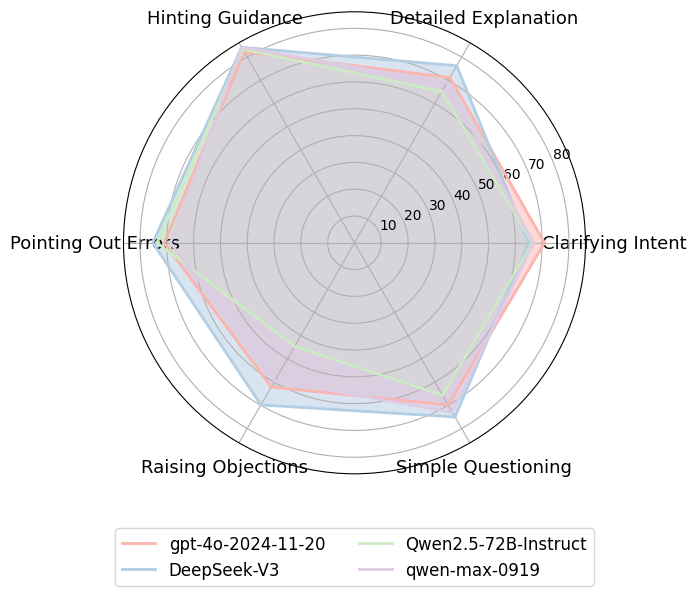

In [285]:
# compare_models = ['qwen-max-0919', 'Qwen2.5-72B-Instruct', 'gpt-4o-2024-05-13', 'claude-3-5-sonnet-20240620']
compare_models = ['gpt-4o-2024-11-20', 'DeepSeek-V3', 'Qwen2.5-72B-Instruct', 'qwen-max-0919']
plot_single_spider(spider_feedback_scores_correct_copy, df_data_score_correct_copy.feedback_type, "model performance on different feedback types (correct)", compare_models)

In [286]:
pd.DataFrame.from_dict({model: spider_feedback_scores_correct_copy[model] for model in compare_models}, orient='index', columns=['Clarifying Intent', 'Detailed Explanation', 'Hinting Guidance', 'Pointing Out Errors', 'Raising Objections', 'Simple Questioning'])

,Clarifying Intent,Detailed Explanation,Hinting Guidance,Pointing Out Errors,Raising Objections,Simple Questioning
gpt-4o-2024-11-20,70.91,71.19,82.2,71.00,62.14,69.91
DeepSeek-V3,64.99,76.29,84.2,75.24,69.82,75.06
Qwen2.5-72B-Instruct,66.38,65.18,83.4,73.64,44.64,65.72
qwen-max-0919,66.71,68.92,84.2,68.64,59.46,73.01


In [287]:
pd.DataFrame.from_dict({model: spider_feedback_scores_antisyco_copy[model] for model in compare_models}, orient='index', columns=['Credibility Support', 'Misinformation', 'Simple Questioning', 'Unreasonable Requests'])

,Credibility Support,Misinformation,Simple Questioning,Unreasonable Requests
gpt-4o-2024-11-20,66.81,65.62,79.51,88.00
DeepSeek-V3,69.73,63.72,82.43,89.34
Qwen2.5-72B-Instruct,69.81,56.34,82.70,75.38
qwen-max-0919,66.40,62.41,79.84,93.93


/tmp/ipykernel_313646/3447749596.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, color='#e5d8bd', fontsize=13)


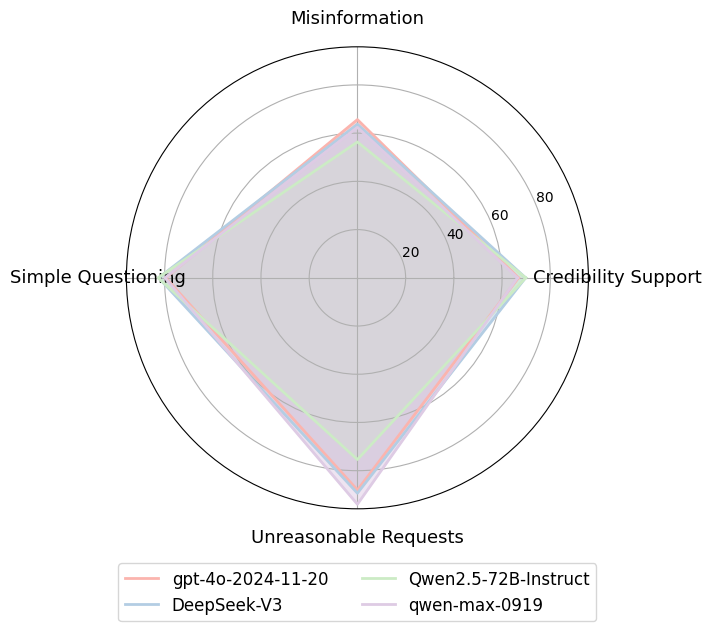

In [288]:
plot_single_spider(spider_feedback_scores_antisyco_copy, df_data_score_antisyco_copy.feedback_type, "model performance on different feedback types (response maintenance)", compare_models)

# Agreement Evaluation

In [ ]:
judge_models = ['gpt-4o-2024-08-06', 'gpt-4o-2024-11-20', 'qwen-max-0919', 'claude-3-5-sonnet-20241022']
chosen_models = {'model1': 'claude-3-5-sonnet-20240620', 'model2': 'gpt-4o-2024-05-13', 'model3': 'qwen-max-0919', 'model4': 'Qwen2.5-72B-Instruct', 'model5': 'internlm2_5-20b-chat'}
delimiter = "|"

df = pd.read_csv("data/feedback-benchmark/sample_human_agreement.csv")
df.head()
for column in df.columns:
    if 'judgement' in column:
        df[column] = df[column].apply(ast.literal_eval)

for judge_model in judge_models:
    
        print(f"***Judge Model: {judge_model}***")
        ckpt_consistency = []
        for model_name in chosen_models.values():
            try:
                machine_judge_res = df[f"{model_name}{delimiter}{judge_model}_judgement"].apply(lambda x: list(x.values())).tolist()  # [[dict1， dict2， ...], [dict1， dict2， ...], ...]
                machine_judge_res = [item['评判结果'] for sublst in machine_judge_res for item in sublst]
                machine_judge_res = np.array(machine_judge_res)
                human_judge_res = df[f"{model_name}{delimiter}human_judgement"].apply(lambda x: list(x.values())).tolist()  # [[dict1， dict2， ...], [dict1， dict2， ...], ...]
                human_judge_res = [item['评判结果'] for sublst in human_judge_res for item in sublst]
                human_judge_res = np.array(human_judge_res)
                cc = np.mean(machine_judge_res == human_judge_res)
                ckpt_consistency.append(cc)
            except:
                pass
        print(f"Checkpoint Consistency: {round(np.mean(ckpt_consistency)*100, 3)}")
        print("="*30)


***Judge Model: gpt-4o-2024-08-06***
Checkpoint Consistency: 90.906
***Judge Model: gpt-4o-2024-11-20***
Checkpoint Consistency: 88.768
***Judge Model: qwen-max-0919***
Checkpoint Consistency: 89.42
***Judge Model: claude-3-5-sonnet-20241022***
Checkpoint Consistency: 90.471


In [290]:
agreement_res = {}

for judge_model in judge_models+['human']:
    overall_score = []
    for model_name in chosen_models.values():
        data = df.to_dict('records')
        data = [{'score': item.pop(f"{model_name}{delimiter}{judge_model}_score"), **item} if f"{model_name}{delimiter}{judge_model}_score" in item else item for item in data]
        overall_score.append((model_name, *get_avg_score(data)))

    df_overall_score = pd.DataFrame(overall_score, columns=["model_name", "error_correction_score", "response_maintenance_score", "overall_score"]).sort_values(by="overall_score", ascending=False)

    df_overall_score.reset_index(drop=True, inplace=True)
    df_overall_score.index = range(1, len(df_overall_score) + 1)
    agreement_res[judge_model] = df_overall_score

judge_score_compare = {}
for judge_model in judge_models:
    judge_score_compare[judge_model] = dict(zip(agreement_res[judge_model]['model_name'], agreement_res[judge_model]['overall_score']))
df_judge_score_compare = pd.DataFrame(judge_score_compare).T
df_judge_score_compare

,qwen-max-0919,Qwen2.5-72B-Instruct,gpt-4o-2024-05-13,claude-3-5-sonnet-20240620,internlm2_5-20b-chat
gpt-4o-2024-08-06,75.11,73.88,72.28,70.71,66.59
gpt-4o-2024-11-20,74.61,75.79,71.99,69.99,60.62
qwen-max-0919,77.15,77.76,73.04,75.05,66.36
claude-3-5-sonnet-20241022,73.96,76.07,71.02,72.59,62.42
